Paragraph generation using Transformer models:

We will attempt to generate a paragraph of text in Hindi language based on a given prompt. We will train the model on the texts taken from wikipdia artices in Hindi language. 


In [ ]:
!pip install torchtext==0.11.2

In [ ]:
# On Colab, you'll see ('1.10.2+cu102', '0.11.2')
import torch, torchtext
torch.__version__, torchtext.__version__

('1.10.2+cu102', '0.11.2')

In [ ]:
from torchtext.vocab import Vectors
import numpy as np
import random

USE_CUDA = torch.cuda.is_available()

if USE_CUDA:
    DEVICE = torch.device('cuda')
    print("Using cuda.")
else:
    DEVICE = torch.device('cpu')
    print("Using cpu.")

random.seed(30255)
np.random.seed(30255)
torch.manual_seed(30255)
if USE_CUDA:
    torch.cuda.manual_seed(30255)

# Change the following to false when training on
# the full set
DEVELOPING = False    
#DEVELOPING = True

if DEVELOPING:
    print('Small development version')
    BATCH_SIZE = 4
    EMBEDDING_SIZE = 20
    MAX_VOCAB_SIZE = 5000
    TRAIN_DATA_SET = "lm-train-small.txt"
    DEV_DATA_SET = "lm-dev-small.txt"
    TEST_DATA_SET = "lm-test-small.txt"
    BPTT_LENGTH = 8
else:
    print('Full version')
    BATCH_SIZE = 32
    EMBEDDING_SIZE = 300
    MAX_VOCAB_SIZE = 100000
    TRAIN_DATA_SET = "lm-train.txt"
    DEV_DATA_SET = "lm-dev.txt"
    TEST_DATA_SET = "lm-test.txt"
    BPTT_LENGTH = 32



Using cuda.
Full version


In [ ]:
# For uploading data to Colab see, e.g., 
# https://medium.com/@philipplies/transferring-data-from-google-drive-to-google-cloud-storage-using-google-colab-96e088a8c041    
# COLAB = False
COLAB = True
if COLAB:
    from google.colab import drive 
    drive.mount('/content/gdrive')
    PATH = "gdrive/My Drive/AML_Project/datasets_hindi_wiki"
else:
    PATH = "/Users/tiru/Documents/Documents_new/Adv_ML/hindi_wiki_55k"
    
LOG_FILE = "language-model.log"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# This command is to unmount gdrive - need it sometimes
#!fusermount -u gdrive

In [ ]:
TEXT = torchtext.legacy.data.Field(lower=True)

train, val, test = torchtext.legacy.datasets.LanguageModelingDataset.splits(path=PATH, 
    train=TRAIN_DATA_SET, validation=DEV_DATA_SET, test=TEST_DATA_SET, text_field=TEXT)

TEXT.build_vocab(train, max_size=MAX_VOCAB_SIZE)
VOCAB_SIZE = len(TEXT.vocab)

print(f'Vocabulary size: {VOCAB_SIZE}')

train_iter, val_iter, test_iter = torchtext.legacy.data.BPTTIterator.splits(
    (train, val, test), batch_size=BATCH_SIZE, device=DEVICE, bptt_len=BPTT_LENGTH, 
    repeat=False)

Vocabulary size: 100002


In [ ]:
it = iter(train_iter)
batch=next(it)
print("The first three text/target sequences from the first batch are:\n")
indent = " " * 4
for j in range(3):
    print(indent, f"Text Sequence {j}:", 
          " ".join([TEXT.vocab.itos[i] for i in batch.text[:,j].data]))
    print(indent, f"Target Sequence {j}:",
          " ".join([TEXT.vocab.itos[i] for i in batch.target[:,j].data]))
    print()
 
print(f"Each sequence has BPTT_LENGTH = {BPTT_LENGTH}.\n")
print("Also the sequences continue in the next batch!\n")
batch = next(it)
for j in range(3):
    print(indent, f"Text Sequence {j}:", 
          " ".join([TEXT.vocab.itos[i] for i in batch.text[:,j].data]))
    print(indent, f"Target Sequence {j}:",
          " ".join([TEXT.vocab.itos[i] for i in batch.target[:,j].data]))
    print()

The first three text/target sequences from the first batch are:

     Text Sequence 0: <eos> भारतीय मोर या नीला मोर दक्षिण एशिया के देशी तीतर परिवार का एक बड़ा और चमकीले रंग का पक्षी है, दुनिया के अन्य भागों में यह अर्द्ध-जंगली के रूप में परिचित
     Target Sequence 0: भारतीय मोर या नीला मोर दक्षिण एशिया के देशी तीतर परिवार का एक बड़ा और चमकीले रंग का पक्षी है, दुनिया के अन्य भागों में यह अर्द्ध-जंगली के रूप में परिचित है।

     Text Sequence 1: पतला स्तर होता है, परंतु स्त्रियों में <unk> गुहा, गर्भाशय गुहा तथा <unk> द्वारा यह बाह्य वातावरण में खुलती है। इस पेरिटोनियम कला की परतों के द्वारा आशय उदर गुहा में लटके
     Target Sequence 1: स्तर होता है, परंतु स्त्रियों में <unk> गुहा, गर्भाशय गुहा तथा <unk> द्वारा यह बाह्य वातावरण में खुलती है। इस पेरिटोनियम कला की परतों के द्वारा आशय उदर गुहा में लटके रहते

     Text Sequence 2: चार वर्ष के उत्तर-स्नातक पर्यवेक्षित चिकित्सा-कार्य से लेकर तीन से छः वर्षों के डॉक्टर की उपाधि तक होती है, जिसमें नैदानिक स्थापन शामिल होती है। अमेरिका में नैदा

In [ ]:
import torch
import torch.nn as nn


class RNNLM(nn.Module):
    """ Container module with an linear encoder/embedding, an RNN module, and a linear decoder.
    """

    def __init__(self, rnn_type, vocab_size, embedding_dim, hidden_dim, num_layers, 
                 dropout=0.5):
        ''' Initialize model parameters corresponding to ---
            - embedding layer
            - recurrent neural network layer---one of LSTM, GRU, or RNN---with 
              optionally more than one layer
            - linear layer to map from hidden vector to the vocabulary
            - optionally, dropout layers.  Dropout layers can be placed after 
              the embedding layer or/and after the RNN layer. Dropout within
              an RNN is only applied when there are two or more num_layers.
            - optionally, initialize the model parameters.
            
            The arguments are:
            
            rnn_type: One of 'LSTM', 'GRU', 'RNN_TANH', 'RNN_RELU'
            vocab_size: size of vocabulary
            embedding_dim: size of an embedding vector
            hidden_dim: size of hidden/state vector in RNN
            num_layers: number of layers in RNN
            dropout: dropout probability.
            
        '''
        super(RNNLM, self).__init__()
        
        ## YOUR CODE HERE ##

        # Embedding layer definition: 
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # RNN definition - depnding on input type requested for RNN
        if rnn_type == 'LSTM':
          self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, dropout=dropout)
        elif rnn_type == 'GRU':
          self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers, dropout=dropout)
        elif rnn_type == 'RNN_TANH':
          self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers, nonlinearity='tanh', dropout=dropout)
        elif rnn_type == 'RNN_RELU':
          self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers, nonlinearity='relu', dropout=dropout)
        else:
          print("Enter one of the four inputs : LSTM/GRU/RNN_TANH/RNN_RELU")  
        
        self.fc = nn.Linear(hidden_dim, vocab_size) 


    def forward(self, input, hidden0):
        ''' 
        Run forward propagation for a given minibatch of inputs using
        hidden0 as the initial hidden state.

        In LSTMs hidden0 = (h_0, c_0). 

        The output of the RNN includes the hidden vector hiddenn = (h_n, c_n).
        Return this as well so that it can be used to initialize the next
        batch.
        
        Unlike previous homework sets do not apply softmax or logsoftmax here, since we'll use
        the more efficient CrossEntropyLoss.  See 
        https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html.
        '''

        embeds = self.embedding(input)
        output_n, hidden_n = self.rnn(embeds, hidden0)
        output_n = self.fc(output_n)

        return output_n, hidden_n

In [ ]:
def evaluate(model, data):
    '''
    Evaluate the model on the given data.
    '''

    model.eval()
    it = iter(data)
    total_count = 0. # Number of target words seen
    total_loss = 0. # Loss over all target words
    with torch.no_grad():
        # No gradients need to be maintained during evaluation
        # There are no hidden tensors for the first batch, and so will default to zeros.
        hidden = None 
        for i, batch in enumerate(it):
            ''' Do the following:
                - Extract the text and target from the batch, and if using CUDA (essentially, using GPUs), place 
                  the tensors on cuda, using a commands such as "text = text.cuda()".  More details are at
                  https://pytorch.org/docs/stable/notes/cuda.html.
                - Pass the hidden state vector from output of previous batch as the initial hidden vector for
                  the current batch. 
                - Call forward propagation to get output and final hidden state vector.
                - Compute the cross entropy loss
                - The loss_fn computes the average loss per target word in the batch.  Count the number of target
                  words in the batch (it is usually the same, except for the last batch), and use it to track the 
                  total count (of target words) and total loss see so far over all batches.
            '''
            text, target = batch.text, batch.target
            if USE_CUDA:
                text, target = text.cuda(), target.cuda()
            output, hidden = model(text, hidden)
            loss = loss_fn(output.view(-1, output.size(-1)), target.view(-1))
                  
            total_count += np.multiply(*text.size())
            total_loss += loss.item()*np.multiply(*text.size())
                
    loss = total_loss / total_count
    model.train()
    return loss

model: RNNLM(
  (embedding): Embedding(100002, 300)
  (rnn): LSTM(300, 300, num_layers=2, dropout=0.5)
  (fc): Linear(in_features=300, out_features=100002, bias=True)
)
use_cuda_status:  True
Training Epoch # 1
At iteration 1000 the loss is 7.117.
At iteration 2000 the loss is 6.626.
Iteration 2000, the validation loss is 6.519.
At iteration 3000 the loss is 6.451.
At iteration 4000 the loss is 6.129.
Iteration 4000, the validation loss is 6.138.
At iteration 5000 the loss is 6.189.
Training Epoch # 2
At iteration 1000 the loss is 5.842.
At iteration 2000 the loss is 5.728.
Iteration 2000, the validation loss is 5.890.
At iteration 3000 the loss is 5.663.
At iteration 4000 the loss is 5.304.
Iteration 4000, the validation loss is 5.764.
At iteration 5000 the loss is 5.542.
Training Epoch # 3
At iteration 1000 the loss is 5.198.
At iteration 2000 the loss is 5.222.
Iteration 2000, the validation loss is 5.688.
At iteration 3000 the loss is 5.280.
At iteration 4000 the loss is 4.848.
Ite

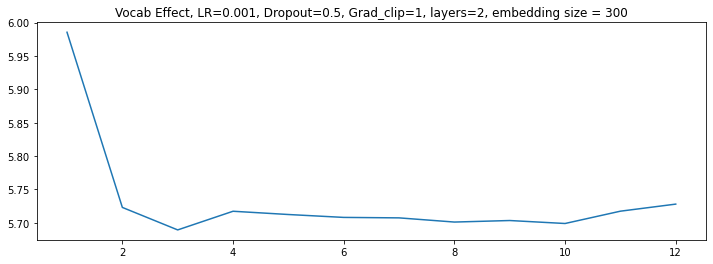

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 4)
GRAD_CLIP = 1.
NUM_EPOCHS = 12
CUDA_LAUNCH_BLOCKING = "1"
NUM_LAYERS = 2
DROPOUT = 0.5

def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if h is None:
        return None
    elif isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)


''' Do the following:
    - Extract the text and target from the batch, and if using CUDA (essentially, using GPUs), place 
      the tensors on cuda, using a commands such as "text = text.cuda()".  More details are at
      https://pytorch.org/docs/stable/tensors.html#torch.Tensor.cuda -DONE
    - Pass the hidden state vector from output of previous batch as the initial hidden vector for
      the current batch. But detach each tensor in the hidden state vector using tensor.detach() or
      the provided repackage_hidden(). See
      https://pytorch.org/docs/master/generated/torch.Tensor.detach_.html#torch-tensor-detach
    - Zero out the model gradients to reset backpropagation for current batch
    - Call forward propagation to get output and final hidden state vector.
    - Compute the cross entropy loss
    - Run back propagation to set the gradients for each model parameter.
    - Clip the gradients that may have exploded. See Sec 5.2.4 in the Goldberg textbook, and
      https://pytorch.org/docs/master/generated/torch.nn.utils.clip_grad_norm_.html#torch-nn-utils-clip-grad-norm
    - Run a step of gradient descent. 
    - Print the batch loss after every few iterations. (Say every 100 when developing, every 1000 otherwise.)
    - Evaluate your model on the validation set after every, say, 10000 iterations and save it to val_losses. If
      your model has the lowest validation loss so far, copy it to best_model. For that it is recommended that
      copy the state_dict rather than use deepcopy, since the latter doesn't work on Colab.  See discussion at 
      https://discuss.pytorch.org/t/deep-copying-pytorch-modules/13514. This is Early Stopping and is described
      in Sec 2.3.1 of Lecture notes by Cho: 
      https://github.com/nyu-dl/NLP_DL_Lecture_Note/blob/master/lecture_note.pdf
'''


model = RNNLM("LSTM", VOCAB_SIZE, EMBEDDING_SIZE, EMBEDDING_SIZE, NUM_LAYERS, DROPOUT)
print("model:", model)
print("use_cuda_status: ", USE_CUDA)
if USE_CUDA:
  model = model.cuda()

loss_fn = nn.CrossEntropyLoss() ## Used instead of NLLLoss.
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
val_losses = []
epoch_val_loss=[]
best_model = RNNLM("LSTM", VOCAB_SIZE, EMBEDDING_SIZE, EMBEDDING_SIZE, NUM_LAYERS, DROPOUT)


for epoch in range(NUM_EPOCHS):
    print("Training Epoch #", epoch+1)
    model.train()
    log_interval = 1000
    it = iter(train_iter)
    # There are no hidden tensors for the first batch, and so will default to zeros.
    hidden = None

    for i, batch in enumerate(it):
      model.zero_grad()
      text, target = batch.text, batch.target
      if USE_CUDA:
        text, target = text.cuda(), target.cuda()
      output_n, hidden_n = model(text, hidden)
      hidden = repackage_hidden(hidden_n)
      loss = loss_fn(output_n.view(-1, output_n.size(-1)), target.view(-1))

      loss.backward()
      optimizer.step()
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=GRAD_CLIP, norm_type=2.0, error_if_nonfinite=False)

      if i % log_interval == 0 and i > 0:
        print(f'At iteration {i} the loss is {loss:.3f}.')

      if i % 2000 == 0 and i > 0:
        val_loss = evaluate(model, val_iter)
        print(f'Iteration {i}, the validation loss is {val_loss:.3f}.')
        val_losses.append(val_loss)
        if val_loss <= min(val_losses):
          torch.save(model.state_dict(), "gdrive/My Drive/AML_Project/best_model.pt")

    epoch_loss = evaluate(model, val_iter)
    epoch_val_loss.append(epoch_loss)

best_model.load_state_dict(torch.load("gdrive/My Drive/AML_Project/best_model.pt")) 
plt.plot(range(1, NUM_EPOCHS+1), epoch_val_loss)
plt.title("Vocab Effect, LR=0.001, Dropout=0.5, Grad_clip=1, layers=2, embedding size = 300")
plt.savefig("Layer_effect.png")

In [ ]:
'''
Evaluate the loss of best_model on the validation set and compute its perplexity.
'''
if USE_CUDA:
  best_model = best_model.cuda()
val_loss = evaluate(best_model, val_iter)
print("perplexity: ", np.exp(val_loss))

perplexity:  271.2047316660911


In [ ]:
'''
Evaluate the loss of best_model on the test set and compute its perplexity.
'''
test_loss = evaluate(best_model, test_iter)
print("perplexity: ", np.exp(test_loss))

perplexity:  257.0131939681911


In [ ]:
# Sentence generation in Hindi
# Reference: https://www.analyticsvidhya.com/blog/2020/08/build-a-natural-language-generation-nlg-system-using-pytorch/

import torch.nn.functional as F
# predict next token
def predict(best_model, tkn, h=None):
         
  # tensor inputs
  x = np.array([[TEXT.vocab.stoi[tkn]]])
  inputs = torch.from_numpy(x)
  
  # push to GPU
  inputs = inputs.cuda()

  # detach hidden state from history
  h = repackage_hidden(h)

  # get the output of the model
  out, h = best_model(inputs, h)

  # get the token probabilities
  p = F.softmax(out.view(-1, out.size(-1)) , dim=1)

  # get indices of top 3 or 5 values
  top_n_idx = p.argsort().reshape(-1)[-3:]
  #top_n_idx = p.argsort()[-1][-3:]

  # randomly select one of the three indices
  sampled_token_index = top_n_idx[random.sample([0,1,2],1)[0]]
  #print(sampled_token_index)


  # return the encoded value of the predicted char and the hidden state
  return TEXT.vocab.itos[sampled_token_index], h


# function to generate text
def sample(best_model, size, prime='it is'):
        
    # push to GPU
    #best_model.cuda()
    
    best_model.eval()

    # batch size is 1
    h = None

    toks = prime.split()

    # predict next token
    for t in prime.split():
      token, h = predict(best_model, t, h)
    
    toks.append(token)

    # predict subsequent tokens
    for i in range(size-1):
        token, h = predict(best_model, toks[-1], h)
        toks.append(token)

    return ' '.join(toks)

words_list = ["सिनेमा", "प्राचीन", "मलयालम", "शरीर", "भौतिक", "प्रयोग", "एक"]
for i in words_list:
  print(i," :", sample(best_model, 50, prime=i))

सिनेमा  : सिनेमा का सामना करना पड़ा. इस प्रकार के <unk> के लिए एक बार जब ब्लोर के <unk> के लिए एक नया <unk> था जिसे <unk> के लिए किया जाता था, जिसे <unk> कहा गया। इस तरह के लिए एक <unk> के लिए एक विशेष रूप से, एक <unk> <unk> का एक
प्राचीन  : प्राचीन <unk> प्रस्तर साहित्य में स्थित है । यह <unk> का एक प्रमुख अंग है, जो कि <unk> का एक महत्वपूर्ण अंग है। इस ग्रंथ में एक प्रमुख परकोटा <unk> <unk> <unk> <unk> और <unk> <unk> का <unk> <unk> <unk> <unk> और <unk> <unk> का <unk> <unk> के साथ ही साथ
मलयालम  : मलयालम के रूप से लेकर <unk> के <unk> <unk> <unk> के साथ ही साथ <unk> और अन्य अन्य संस्कृतियां उल्टी <unk> और वृत्ताकार, लाइअर के <unk> के साथ <unk> के साथ साध्यता के <unk> <unk> और <unk> <unk> जैसे बांसुरी, क्र, <unk> <unk> <unk> <unk> <unk> आदि। <eos> <eos> <unk> <unk>
शरीर  : शरीर के कारण ही न ही एक ही <unk> या किसी एक तरह के लिए एक दूसरे के लिए <unk> होता है। <eos> <unk> के कैटरपिलर के लिए एक दूसरे को एक ही समय में एक दूसरे से जुड़ते हैं। <eos> कैटरपिलर का प्रयोग एक <unk> के साथ एक <unk> 

In [ ]:
sen1 = ("तस्मानियाई डैविल एक मांसाहारी धानीप्राणी है जो अब केवल ऑस्ट्रेलिया के द्वीप राज्य तस्मानिया के जंगलों में ही पाया जाता है।" 
        "इसका आकार एक"
        "छोटे कुत्ते के बराबर होता है।"
         "1936 में थायलेसीन​ के विलुप्त होने के बाद यह दुनिया का सबसे बड़ा मांसाहारी धानीप्राणी बन गया।")

sen2 = ("तस्मानियाई डैविल एक मांसाहारी धानीप्राणी है जो अब केवल ऑस्ट्रेलिया के द्वीप राज्य तस्मानिया के जंगलों में ही पाया जाता है।" 
        "इसका आकार" 
        "समुद्र के बराबर होता है।"
         "1936 में थायलेसीन​ के विलुप्त होने के बाद यह दुनिया का सबसे बड़ा मांसाहारी धानीप्राणी बन गया।")

sen3 = ("तस्मानियाई डैविल एक मांसाहारी धानीप्राणी है जो अब केवल ऑस्ट्रेलिया के द्वीप राज्य तस्मानिया के जंगलों में ही पाया जाता है।" 
        "इसका आकार" 
        "एक पेंसिल के बराबर होता है।"
         "1936 में थायलेसीन​ के विलुप्त होने के बाद यह दुनिया का सबसे बड़ा मांसाहारी धानीप्राणी बन गया।")

sen4 = ("डैविल एक मांसाहारी प्रधानमंत्री है जो अब केवल ऑस्ट्रेलिया के द्वीप राज्य तस्मानिया के जंगलों में ही पाया जाता है।" 
        "इसका आकार क्यूबा बराबर होता है।"
         "प्लास्टिक के विलुप्त होने के बाद यह दुनिया का सबसे बड़ा मांसाहारी धानीप्राणी बन गया।")

sen5 = sen1.split()
random.shuffle(sen5)
sen5 = " ".join(sen5)

sen6 = " ".join(['डैविल एक मांसाहारी धानीप्राणी है']*8)

sen_list = [sen1, sen2, sen3, sen4, sen5, sen6]

for sen in sen_list:

    print(sen)
    with open(PATH + "temp_sentence.txt", 'w') as text_file:
        print(sen, file = text_file)

    temp_ds = torchtext.legacy.datasets.LanguageModelingDataset(path=PATH + 'temp_sentence.txt', text_field=TEXT)


    sen_iter = torchtext.legacy.data.BPTTIterator(temp_ds, batch_size=BATCH_SIZE, device=DEVICE, 
                                                  bptt_len=BPTT_LENGTH, repeat=False)
        
    sen_loss = evaluate(best_model, sen_iter)
    print("perplexity: ", np.exp(sen_loss))
    print()

तस्मानियाई डैविल एक मांसाहारी धानीप्राणी है जो अब केवल ऑस्ट्रेलिया के द्वीप राज्य तस्मानिया के जंगलों में ही पाया जाता है।इसका आकार एकछोटे कुत्ते के बराबर होता है।1936 में थायलेसीन​ के विलुप्त होने के बाद यह दुनिया का सबसे बड़ा मांसाहारी धानीप्राणी बन गया।
perplexity:  36676.64020487135

तस्मानियाई डैविल एक मांसाहारी धानीप्राणी है जो अब केवल ऑस्ट्रेलिया के द्वीप राज्य तस्मानिया के जंगलों में ही पाया जाता है।इसका आकारसमुद्र के बराबर होता है।1936 में थायलेसीन​ के विलुप्त होने के बाद यह दुनिया का सबसे बड़ा मांसाहारी धानीप्राणी बन गया।
perplexity:  38459.00898318032

तस्मानियाई डैविल एक मांसाहारी धानीप्राणी है जो अब केवल ऑस्ट्रेलिया के द्वीप राज्य तस्मानिया के जंगलों में ही पाया जाता है।इसका आकारएक पेंसिल के बराबर होता है।1936 में थायलेसीन​ के विलुप्त होने के बाद यह दुनिया का सबसे बड़ा मांसाहारी धानीप्राणी बन गया।
perplexity:  15501.205243912675

डैविल एक मांसाहारी प्रधानमंत्री है जो अब केवल ऑस्ट्रेलिया के द्वीप राज्य तस्मानिया के जंगलों में ही पाया जाता है।इसका आकार क्यूबा बराबर होता है।प

In [ ]:
#(i) Substitute LSTM with a GRU

model_GRU = RNNLM("GRU", VOCAB_SIZE, EMBEDDING_SIZE, EMBEDDING_SIZE, 2, dropout=0.5)
print("model_GRU:", model_GRU)
print("use_cuda_status: ", USE_CUDA)
if USE_CUDA:
  model_GRU = model_GRU.cuda()

loss_fn = nn.CrossEntropyLoss() ## Used instead of NLLLoss.
learning_rate = 0.001
optimizer = torch.optim.Adam(model_GRU.parameters(), lr=learning_rate)
val_losses = []
best_model_GRU = RNNLM("GRU", VOCAB_SIZE, EMBEDDING_SIZE, EMBEDDING_SIZE, 2, dropout=0.5)


for epoch in range(NUM_EPOCHS):
    model_GRU.train()
    log_interval = 1000
    it = iter(train_iter)
    # There are no hidden tensors for the first batch, and so will default to zeros.
    hidden = None

    for i, batch in enumerate(it):
      model_GRU.zero_grad()
      text, target = batch.text, batch.target
      if USE_CUDA:
        text, target = text.cuda(), target.cuda()
      output_n, hidden_n = model_GRU(text, hidden)
      hidden = repackage_hidden(hidden_n)
      loss = loss_fn(output_n.view(-1, output_n.size(-1)), target.view(-1))

      loss.backward()
      optimizer.step()
      nn.utils.clip_grad_norm_(model_GRU.parameters(), max_norm=GRAD_CLIP, norm_type=2.0, error_if_nonfinite=False)

      if i % log_interval == 0 and i > 0:
        print(f'At iteration {i} the loss is {loss:.3f}.')

      if i % 2000 == 0 and i > 0:
        val_loss = evaluate(model_GRU, val_iter)
        print(f'Iteration {i}, the validation loss is {val_loss:.3f}.')
        val_losses.append(val_loss)
        if val_loss <= min(val_losses):
          torch.save(model_GRU.state_dict(), "gdrive/My Drive/AML_Project/best_model_GRU.pt")

best_model_GRU.load_state_dict(torch.load("gdrive/My Drive/AML_Project/best_model_GRU.pt")) 

model_GRU: RNNLM(
  (embedding): Embedding(100002, 300)
  (rnn): GRU(300, 300, num_layers=2, dropout=0.5)
  (fc): Linear(in_features=300, out_features=100002, bias=True)
)
use_cuda_status:  True
At iteration 1000 the loss is 7.962.
At iteration 2000 the loss is 7.841.
Iteration 2000, the validation loss is 7.796.
At iteration 3000 the loss is 6.665.
At iteration 4000 the loss is 6.094.
Iteration 4000, the validation loss is 6.182.
At iteration 5000 the loss is 6.059.
At iteration 1000 the loss is 5.758.
At iteration 2000 the loss is 5.692.
Iteration 2000, the validation loss is 5.723.
At iteration 3000 the loss is 5.535.
At iteration 4000 the loss is 5.112.
Iteration 4000, the validation loss is 5.566.
At iteration 5000 the loss is 5.346.
At iteration 1000 the loss is 5.055.
At iteration 2000 the loss is 5.166.
Iteration 2000, the validation loss is 5.473.
At iteration 3000 the loss is 5.195.
At iteration 4000 the loss is 4.718.
Iteration 4000, the validation loss is 5.406.
At iteratio

<All keys matched successfully>

In [ ]:
# Perplexity score on validation and test datasets
'''
Evaluate the loss of best_model on the validation set and compute its perplexity.
'''
if USE_CUDA:
  best_model_GRU = best_model_GRU.cuda()
val_loss = evaluate(best_model_GRU, val_iter)
print("perplexity on validation set: ", np.exp(val_loss))

'''
Evaluate the loss of best_model on the test set and compute its perplexity.
'''
test_loss = evaluate(best_model_GRU, test_iter)
print("perplexity on test set: ", np.exp(test_loss))

perplexity on validation set:  183.41251158988106
perplexity on test set:  176.19636645956507


In [ ]:
# Sentence generation in Hindi using GRU model

import torch.nn.functional as F
# predict next token
def predict(best_model_GRU, tkn, h=None):
         
  # tensor inputs
  x = np.array([[TEXT.vocab.stoi[tkn]]])
  inputs = torch.from_numpy(x)
  
  # push to GPU
  inputs = inputs.cuda()

  # detach hidden state from history
  h = repackage_hidden(h)

  # get the output of the model
  out, h = best_model(inputs, h)

  # get the token probabilities
  p = F.softmax(out.view(-1, out.size(-1)) , dim=1)

  # get indices of top 3 or 5 values
  top_n_idx = p.argsort().reshape(-1)[-3:]
  #top_n_idx = p.argsort()[-1][-3:]

  # randomly select one of the three indices
  sampled_token_index = top_n_idx[random.sample([0,1,2],1)[0]]
  #print(sampled_token_index)

  # return the encoded value of the predicted char and the hidden state
  return TEXT.vocab.itos[sampled_token_index], h


# function to generate text
def sample(model, size, prime='it is'):
    
    model.eval()

    # batch size is 1
    h = None

    toks = prime.split()

    # predict next token
    for t in prime.split():
      token, h = predict(best_model, t, h)
    
    toks.append(token)

    # predict subsequent tokens
    for i in range(size-1):
        token, h = predict(best_model, toks[-1], h)
        toks.append(token)

    return ' '.join(toks)

words_list = ["सिनेमा", "प्राचीन", "मलयालम", "शरीर", "भौतिक", "प्रयोग", "एक"]
for i in words_list:
  print(i," :", sample(best_model_GRU, 50, prime=i))

सिनेमा  : सिनेमा के लिए एक नया और हिस्सा था। इस प्रकार, एक बार एक नया आश्चर्य है की इस तरह के एक नज़रिये है जो कि एक <unk> के लिए dfa के रूप में, <unk> <unk> के रूप में जाना गया है। <eos> एक अन्य कैटरपिलर के साथ एक <unk> के रूप
प्राचीन  : प्राचीन और अरुणाचल में <unk> के रूप में, यह <unk> की तरह के लिए जाना जा रहा है कि <unk> <unk> के <unk> <unk> के रूप में एक नया स्थान था। <unk> में एक रंटजन के <unk> में से एक ही <unk> का एक हिस्सा <unk> के <unk> के लिए <unk>
मलयालम  : मलयालम और अधिक <unk> के साथ ही <unk> <unk> <unk> और <unk> के बीच के रूप में। यह <unk> के लिए <unk> <unk> के <unk> में <unk> की <unk> <unk> के साथ ही साथ <unk> और <unk> के बीच के एक <unk> का <unk> <eos> <unk> <eos> <unk> <unk> के रूप
शरीर  : शरीर ही <unk> <unk> और अन्य संस्कृतियों के लिए भी एक विशेष <unk> के लिए एक <unk> का प्रयोग किया गया है। यह पराभक्ति का एक महत्वपूर्ण अंग है जो <unk> के साथ <unk> में स्थित है। <eos> ग्रिल्स के अनुसार, अली के पिता ने <unk> के रूप में अपने <unk>
भौतिक  : भौतिक ही <unk> है। <eos> <unk> क

In [ ]:
# Perplexity scoring for the 5 setences using GRU model

sen1 = ("तस्मानियाई डैविल एक मांसाहारी धानीप्राणी है जो अब केवल ऑस्ट्रेलिया के द्वीप राज्य तस्मानिया के जंगलों में ही पाया जाता है।" 
        "इसका आकार एक"
        "छोटे कुत्ते के बराबर होता है।"
         "1936 में थायलेसीन​ के विलुप्त होने के बाद यह दुनिया का सबसे बड़ा मांसाहारी धानीप्राणी बन गया।")

sen2 = ("तस्मानियाई डैविल एक मांसाहारी धानीप्राणी है जो अब केवल ऑस्ट्रेलिया के द्वीप राज्य तस्मानिया के जंगलों में ही पाया जाता है।" 
        "इसका आकार" 
        "समुद्र के बराबर होता है।"
         "1936 में थायलेसीन​ के विलुप्त होने के बाद यह दुनिया का सबसे बड़ा मांसाहारी धानीप्राणी बन गया।")

sen3 = ("तस्मानियाई डैविल एक मांसाहारी धानीप्राणी है जो अब केवल ऑस्ट्रेलिया के द्वीप राज्य तस्मानिया के जंगलों में ही पाया जाता है।" 
        "इसका आकार" 
        "एक पेंसिल के बराबर होता है।"
         "1936 में थायलेसीन​ के विलुप्त होने के बाद यह दुनिया का सबसे बड़ा मांसाहारी धानीप्राणी बन गया।")

sen4 = ("डैविल एक मांसाहारी प्रधानमंत्री है जो अब केवल ऑस्ट्रेलिया के द्वीप राज्य तस्मानिया के जंगलों में ही पाया जाता है।" 
        "इसका आकार क्यूबा बराबर होता है।"
         "प्लास्टिक के विलुप्त होने के बाद यह दुनिया का सबसे बड़ा मांसाहारी धानीप्राणी बन गया।")

sen5 = sen1.split()
random.shuffle(sen5)
sen5 = " ".join(sen5)

sen6 = " ".join(['डैविल एक मांसाहारी धानीप्राणी है']*8)

sen_list = [sen1, sen2, sen3, sen4, sen5, sen6]

for sen in sen_list:

    print(sen)
    with open(PATH + "temp_sentence.txt", 'w') as text_file:
        print(sen, file = text_file)

    temp_ds = torchtext.legacy.datasets.LanguageModelingDataset(path=PATH + 'temp_sentence.txt', text_field=TEXT)


    sen_iter = torchtext.legacy.data.BPTTIterator(temp_ds, batch_size=BATCH_SIZE, device=DEVICE, 
                                                  bptt_len=BPTT_LENGTH, repeat=False)
        
    sen_loss = evaluate(best_model_GRU, sen_iter)
    print("perplexity: ", np.exp(sen_loss))
    print()

तस्मानियाई डैविल एक मांसाहारी धानीप्राणी है जो अब केवल ऑस्ट्रेलिया के द्वीप राज्य तस्मानिया के जंगलों में ही पाया जाता है।इसका आकार एकछोटे कुत्ते के बराबर होता है।1936 में थायलेसीन​ के विलुप्त होने के बाद यह दुनिया का सबसे बड़ा मांसाहारी धानीप्राणी बन गया।
perplexity:  599.905645076266

तस्मानियाई डैविल एक मांसाहारी धानीप्राणी है जो अब केवल ऑस्ट्रेलिया के द्वीप राज्य तस्मानिया के जंगलों में ही पाया जाता है।इसका आकारसमुद्र के बराबर होता है।1936 में थायलेसीन​ के विलुप्त होने के बाद यह दुनिया का सबसे बड़ा मांसाहारी धानीप्राणी बन गया।
perplexity:  417.4144243634351

तस्मानियाई डैविल एक मांसाहारी धानीप्राणी है जो अब केवल ऑस्ट्रेलिया के द्वीप राज्य तस्मानिया के जंगलों में ही पाया जाता है।इसका आकारएक पेंसिल के बराबर होता है।1936 में थायलेसीन​ के विलुप्त होने के बाद यह दुनिया का सबसे बड़ा मांसाहारी धानीप्राणी बन गया।
perplexity:  248.66167909837358

डैविल एक मांसाहारी प्रधानमंत्री है जो अब केवल ऑस्ट्रेलिया के द्वीप राज्य तस्मानिया के जंगलों में ही पाया जाता है।इसका आकार क्यूबा बराबर होता है।प्